In [17]:
%reset -f

from scipy import linalg
from scipy.sparse import csc_matrix
from scipy.sparse import dia_array
from scipy.sparse import dia_matrix
import scipy.sparse.linalg as splinalg
from numba import njit, prange

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import time as time
from poisson_solver.mesh import Mesh2D
from poisson_solver.solvers import *

In [18]:
def generate_D(n):
    ex = np.ones(n)
    data = np.array([-1 * ex, 4 * ex, -1 * ex])
    offsets = np.array([-1, 0, 1])
    
    return dia_matrix((data, offsets), shape=(n, n)).toarray()

In [19]:
@njit
def kernel(N, A, D, I):
    for i in prange(N):
        for j in prange(N):
            if i == j:
                for ii in prange(N):
                    for jj in prange(N):
                        A[ii+N*i, jj+N*j] = D[ii, jj]
                        
            if np.abs(i - j) == 1:
                for ii in prange(N):
                    for jj in prange(N):
                        A[ii+N*i, jj+N*j] = I[ii, jj]
                        
    return A

In [20]:
def generate_A(N):
    A = np.zeros((N ** 2, N ** 2))
    D = generate_D(N)
    I = -np.identity(N)
    A = kernel(N, A, D, I)
    return A

In [21]:
@njit
def generate_g(g, N, x, y):
    for i in prange(N):
        for j in prange(N):
            r1 = np.square(x[i] + 1.5) + np.square(y[j])
            r2 = np.square(x[i] - 1.5) + np.square(y[j])
            g[i, j] = np.exp(-5 * 0.25 * np.square(r1)) + 3 * 0.5 * np.exp(-np.square(r2))

    return g

In [22]:
def generate_b(N, g, dx):
    # boundaries
    # b = np.zeros(N ** 2)
    b = g.reshape(N, N)
    b[-1,:] = b[1,: ]
    b[:,-1] = b[:,-1]
    b = b.reshape(N ** 2)
    # source
    b += - g * np.square(dx)
    return b

In [23]:
# solve
def psolve(N, g, dx, x, y):
    g = generate_g(g, N, x, y).reshape(N ** 2)
    a = generate_A(N)
    a = csc_matrix(a) # transform to the fitting matrix
    b = generate_b(N, g, dx)
    x = splinalg.spsolve(a, b).reshape(N, N)
    return x

In [24]:
def setup(N):
  min, max = -5, 5
  dx = (max - min) / N

  x = np.linspace(-5, 5, N)
  y = np.linspace(-5, 5, N)
  g = np.zeros([N, N])
  
  return N, g, dx, x, y

In [25]:
t0_32 = time.time()
N, g, dx, x, y = setup(32)
u = psolve(N, g, dx, x, y)
t00_32 = time.time()
t32 = np.round(t00_32 - t0_32, 5)

t0_64 = time.time()
N, g, dx, x, y = setup(64)
u = psolve(N, g, dx, x, y)
t00_64 = time.time()
t64 = np.round(t00_64 - t0_64, 5)

t0_128 = time.time()
N, g, dx, x, y = setup(128)
u = psolve(N, g, dx, x, y)
t00_128 = time.time()
t128 = np.round(t00_128 - t0_128, 5)

m = [[t32, t64, t128], [32, 64, 128]]

In [26]:
def setup32():
    tor       = 1e-7
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5
    nx, ny    = 32, 32
    buff_size = 1
    
    mesh = Mesh2D(nx = nx, ny = ny, buff_size = buff_size)
    mesh.set_xmin(xmin)
    mesh.set_xmax(xmax)
    mesh.set_ymin(ymin)
    mesh.set_ymax(ymax)

    return tor, mesh

In [27]:
def setup64():
    tor       = 1e-7
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5
    nx, ny    = 64, 64
    buff_size = 1
    
    mesh = Mesh2D(nx = nx, ny = ny, buff_size = buff_size)
    mesh.set_xmin(xmin)
    mesh.set_xmax(xmax)
    mesh.set_ymin(ymin)
    mesh.set_ymax(ymax)

    return tor, mesh

In [28]:
def setup128():
    tor       = 1e-7
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5
    nx, ny    = 128, 128
    buff_size = 1
    
    mesh = Mesh2D(nx = nx, ny = ny, buff_size = buff_size)
    mesh.set_xmin(xmin)
    mesh.set_xmax(xmax)
    mesh.set_ymin(ymin)
    mesh.set_ymax(ymax)

    return tor, mesh

In [29]:
'''
Jacobi
'''
def j(name):
  if name == 32:
    ini = setup32()
  elif name == 64:
    ini = setup64()
  elif name == 128:
    ini = setup128()
  else:
    print("No such Grid!")
    quit()
  
  t1 = time.time()
  # name == Gauss or Jacobi or SOR
  j_arr = solve("Jacobi", ini[0], ini[1])
  t2 = time.time()
  
  # print(f"Jocobi{name} -> Time = ", np.round((t2-t1), 2))
  return name, np.round((t2-t1), 5)

In [30]:
'''
Gauss-Seidel
'''
def g(name):
  if name == 32:
    ini = setup32()
  elif name == 64:
    ini = setup64()
  elif name == 128:
    ini = setup128()
  else:
    print("No such Grid!")
    quit()
    
  t3 = time.time()
  # name == Gauss or Jacobi or SOR
  g_arr = solve("Gauss", ini[0], ini[1])
  t4 = time.time()
  
  # print(f"Gauss{name} -> Time = ", np.round((t4-t3), 2))
  return name, np.round((t4-t3), 5)

In [31]:
'''
SOR
'''
def s(name):
  if name == 32:
    ini = setup32()
  elif name == 64:
    ini = setup64()
  elif name == 128:
    ini = setup128()
  else:
    print("(s1) No such Grid!")
    quit()
    
  t5 = time.time()
  # name == Gauss or Jacobi or SOR
  w1, w2 = 1.2, 1.5

  s1_arr = solve("SOR", ini[0], ini[1], w = w1)
  t6 = time.time()

  if name == 32:
    ini = setup32()
  elif name == 64:
    ini = setup64()
  elif name == 128:
    ini = setup128()
  else:
    print("(s2) No such Grid!")
    quit()
  t7 = time.time()
  s2_arr = solve("SOR", ini[0], ini[1], w = w2)
  t8 = time.time()
  
  # print(f"SOR{name} -> Time = ", np.round((t6-t5), 2))
  # print(f"SOR{name} -> Time = ", np.round((t8-t7), 2))
  return name, w1, w2, np.round((t6-t5), 5), np.round((t8-t7), 5)

### Error convergence.

To see how it converge, we could make a of Error vs. Iteration times to see how it converges.

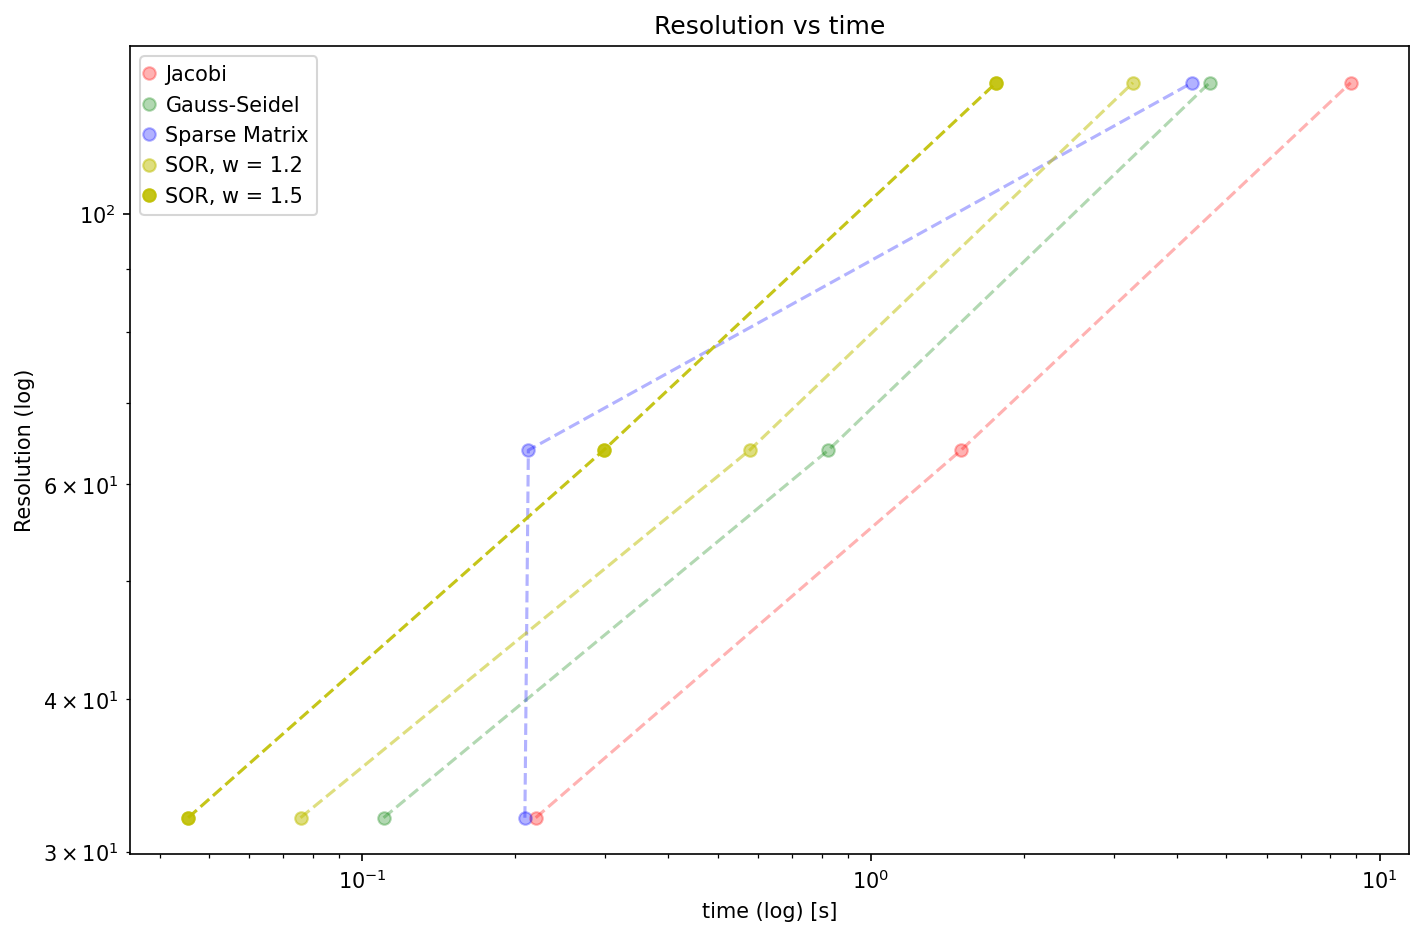

In [32]:
import matplotlib
figure(figsize=(11, 7), dpi=150)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.yscale('log')
plt.xscale('log')

j  = [[j(32)[1], j(64)[1], j(128)[1]], [[j(32)[0], j(64)[0], j(128)[0]]]]
g  = [[g(32)[1], g(64)[1], g(128)[1]], [[g(32)[0], g(64)[0], g(128)[0]]]]
s1 = [[s(32)[3], s(64)[3], s(128)[3]], [s(32)[0], s(64)[0], s(128)[0]]]
s2 = [[s(32)[4], s(64)[4], s(128)[4]], [s(32)[0], s(64)[0], s(128)[0]]]

plt.plot(j[0], j[1][0], '--o', alpha = .3, color = 'r', label = "Jacobi")
plt.plot(g[0], g[1][0], '--o', alpha = .3, color = 'g', label = "Gauss-Seidel")
plt.plot(m[0], m[1], '--o', alpha = .3, color = 'b', label = "Sparse Matrix")
plt.plot(s1[0], s1[1], '--o', alpha = .5, color = 'y', label = f"SOR, w = {s(32)[1]}")
plt.plot(s2[0], s2[1], '--o', alpha = .9, color = 'y', label = f"SOR, w = {s(32)[2]}")

plt.xlabel("time (log) [s]")
plt.ylabel("Resolution (log)")
plt.title("Resolution vs time")
plt.legend(loc = 'best')